In [25]:
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns
import csv
#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA, TruncatedSVD, NMF
from scipy import signal
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster.bicluster import SpectralBiclustering
from sklearn.datasets import samples_generator as sg
from sklearn.metrics import consensus_score


%matplotlib inline

In [2]:
input_path = '../joke_recommender/data/'
df = pd.read_csv(input_path + 'joke_dataframe.csv')
df = df.drop(['Unnamed: 0', 'JokeId'], axis = 1)
df

,User1,User2,User3,User4,User5,User6,User7,User8,User9,User10,...,User73412,User73413,User73414,User73415,User73416,User73417,User73418,User73419,User73420,User73421
0,5.10,-8.79,-3.50,7.14,-8.79,9.22,-4.03,3.11,-3.64,-7.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.90,-0.87,-2.91,-3.88,-0.58,9.37,-1.55,0.92,-3.35,-5.15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.75,1.99,-2.18,-3.06,-0.58,-3.93,-3.64,7.52,-6.46,-3.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-4.17,-4.61,-0.10,0.05,8.98,9.27,-6.99,0.49,-3.40,-1.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.15,5.39,7.52,6.26,7.67,3.45,5.44,-0.58,1.26,4.03,...,3.64,4.32,6.99,-9.66,-8.4,-0.63,9.51,-7.67,-1.6,8.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,6.31,-1.02,3.98,3.93,9.13,1.94,0.44,1.21,6.94,1.12,...,2.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,-4.95,-0.97,-6.46,-2.57,9.17,1.99,-0.78,5.34,5.83,0.78,...,NaN,NaN,NaN,NaN,NaN,0.78,NaN,NaN,NaN,NaN
97,-0.19,4.13,-6.89,1.07,9.17,3.45,-1.02,1.94,5.53,4.76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,3.25,-1.84,-2.33,2.33,9.08,9.17,1.70,3.06,6.55,7.86,...,7.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
X = np.array(df)
scaler = MinMaxScaler(feature_range=(1,2))
scaler.fit(X)
X_transform = scaler.transform(X)
X = np.nan_to_num(X_transform)
X

array([[1.77986437, 1.06564799, 1.33225458, ..., 0.        , 0.        ,
        0.        ],
       [1.7694314 , 1.51386531, 1.36407767, ..., 0.        , 0.        ,
        0.        ],
       [1.60511215, 1.67572156, 1.403452  , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.50391236, 1.79683079, 1.14940669, ..., 0.        , 0.        ,
        0.        ],
       [1.68335942, 1.45897001, 1.39536138, ..., 0.        , 0.        ,
        0.        ],
       [1.74178404, 1.73061686, 1.12297735, ..., 0.        , 0.        ,
        0.        ]])

In [4]:
X = pd.DataFrame(X)
# X.to_csv('scaled_df.csv')
X.head(5)

,0,1,2,3,4,5,6,7,8,9,...,73412,73413,73414,73415,73416,73417,73418,73419,73420,73421
0,1.779864,1.065648,1.332255,1.898623,1.057602,1.992216,1.350401,1.688979,1.246819,1.114807,...,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1,1.769431,1.513865,1.364078,1.291460,1.483653,2.000000,1.503393,1.562608,1.265267,1.250000,...,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2,1.605112,1.675722,1.403452,1.336639,1.483653,1.309808,1.374460,1.943451,1.067430,1.351931,...,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,1.296296,1.302207,1.515642,1.507989,1.979761,1.994811,1.167798,1.537796,1.262087,1.437768,...,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
4,1.782473,1.868138,1.926645,1.850138,1.911780,1.692787,1.934608,1.476053,1.558524,1.742489,...,1.707087,1.765074,1.19598,1.0,1.079971,1.784543,2.0,1.142857,1.595135,1.877922


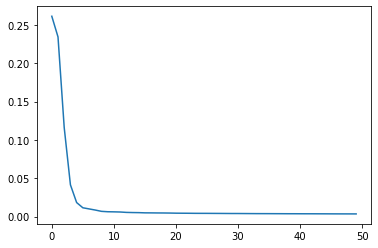

In [5]:
svd = TruncatedSVD(n_components=50)
svd.fit(X)
evr = svd.explained_variance_ratio_
sns.lineplot(x = range(0,50), y = evr)

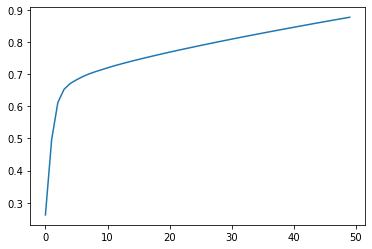

In [6]:
evr_sum = np.cumsum(evr)
sns.lineplot(x = range(0,50), y = evr_sum)

In [7]:
evr_sum

array([0.26147585, 0.49595488, 0.61198758, 0.65335751, 0.67155726,
       0.68295003, 0.69286423, 0.70129417, 0.70802729, 0.71424889,
       0.72032429, 0.7261966 , 0.73156081, 0.7367178 , 0.74176209,
       0.74653112, 0.75125498, 0.75589343, 0.76048352, 0.76497723,
       0.76931475, 0.77359155, 0.77781966, 0.78196333, 0.78607427,
       0.7901689 , 0.79421683, 0.79822541, 0.80217721, 0.80608438,
       0.80998153, 0.81382594, 0.81762502, 0.82137775, 0.82511676,
       0.82883367, 0.83251784, 0.8361751 , 0.83979334, 0.84340109,
       0.84697697, 0.85053428, 0.85408326, 0.85760416, 0.86110308,
       0.86456435, 0.86799764, 0.8714086 , 0.87481397, 0.87818849])

In [8]:
#We chose a evr_sum of 0.8
np.where(np.logical_and (evr_sum > 0.79, evr_sum < 0.81))

(array([25, 26, 27, 28, 29, 30]),)

In [9]:
# We chose 28 principal components
opt_svd = TruncatedSVD(n_components=28)
svd_X = opt_svd.fit_transform(X)

In [10]:
# df2 = df.head(2)
# corr = df2.corr()
# ax = sns.heatmap(corr, vmin = 1, vmax = 2, center = 0, cmap=sns.diverging_palette(20,220,n=200), square = True);

In [11]:
svd_X.shape
svd_X

array([[ 2.42152164e+02, -1.06624425e+02, -4.63975751e+01, ...,
        -2.32384276e+00, -2.34911418e+00,  5.14842881e+00],
       [ 2.53710214e+02, -8.91652033e+01, -5.96193950e+01, ...,
        -3.32881805e+00, -1.96052252e+00,  1.15904317e+01],
       [ 2.38655179e+02, -1.02616829e+02, -5.01897706e+01, ...,
        -5.33911570e+00, -4.18176350e+00,  2.85847561e+00],
       ...,
       [ 1.68627053e+02, -1.04058483e+02,  6.56465869e+01, ...,
         1.78533007e+01,  1.37038462e+01, -1.13093783e+01],
       [ 1.65778014e+02, -1.00300742e+02,  6.12969269e+01, ...,
        -2.20297743e+01,  2.73960965e+01,  1.13563598e+01],
       [ 1.58309692e+02, -1.22893424e+02,  5.66348573e+01, ...,
        -2.64563989e+00,  6.03175037e+00,  6.47513947e-03]])

Text(0.5, 1.05, 'Original dataset')

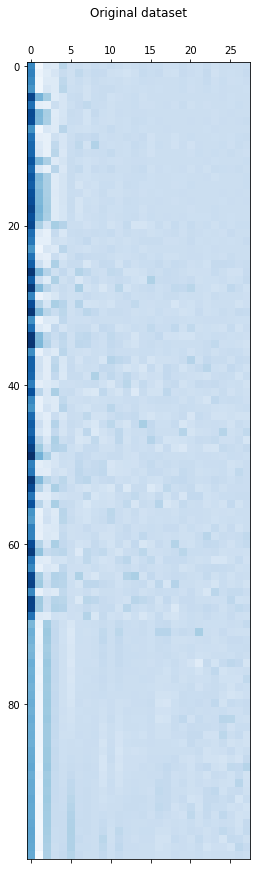

In [12]:
n_clusters = (100,28)
plt.matshow(svd_X, cmap=plt.cm.Blues)
plt.title("Original dataset")

Text(0.5, 1.05, 'Shuffled dataset')

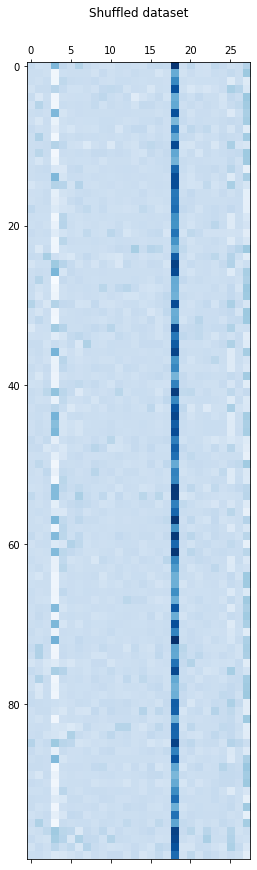

In [13]:
svd_X1, row_idx, col_idx = sg._shuffle(svd_X, random_state=0)
plt.matshow(svd_X1, cmap=plt.cm.Blues)
plt.title("Shuffled dataset")

Text(0.5, 1.05, 'After biclustering; rearranged to show biclusters')

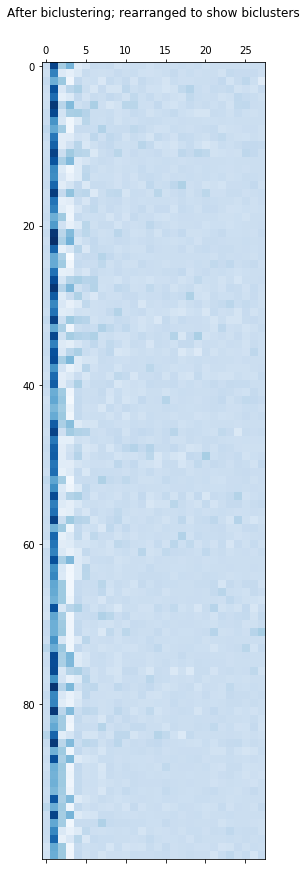

In [23]:
model = SpectralBiclustering(n_clusters=n_clusters, method='log', random_state=0)
model.fit(svd_X1)

fit_data = svd_X1[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

plt.matshow(fit_data, cmap=plt.cm.Blues)
plt.title("After biclustering; rearranged to show biclusters")

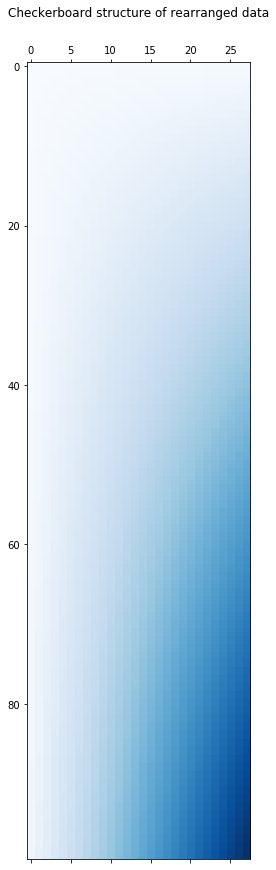

In [15]:
plt.matshow(np.outer(np.sort(model.row_labels_) + 1,
                     np.sort(model.column_labels_) + 1),
            cmap=plt.cm.Blues)
plt.title("Checkerboard structure of rearranged data")

plt.show()

In [17]:
fit_data

array([[  2.91855708, 380.71418264,  70.15536819, ...,  -4.17512765,
         -2.83906268,  -2.59656207],
       [ -9.77007751, 252.42814869, -49.23096483, ...,  10.14215491,
         11.76080455,  -5.50615632],
       [ 12.19369999, 151.28993389,  85.11080444, ...,  28.28242881,
         -4.93688751, -56.47190329],
       ...,
       [ -2.12015066, 312.01357946, -79.31525681, ...,   7.66274142,
         -1.95418648,   5.49180116],
       [-25.97210611, 160.64342577,  83.87828422, ...,  -9.1141703 ,
          5.64007648,  -1.3186208 ],
       [-16.51038269, 152.6241637 ,  83.82338239, ...,  14.04980016,
        -32.42397634,  11.02026403]])

In [27]:
nmf = NMF(n_components=50)
nmf.fit(X)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=50, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [32]:
X.T.head(10)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.779864,1.769431,1.605112,1.296296,1.782473,1.605112,1.762128,1.685968,1.379760,1.440271,...,1.792384,1.273344,1.701095,1.888367,1.561815,1.842984,1.255608,1.503912,1.683359,1.741784
1,1.065648,1.513865,1.675722,1.302207,1.868138,1.518959,1.653650,1.623656,1.071307,1.299377,...,1.766271,1.631579,1.724958,1.560272,1.464063,1.505376,1.508206,1.796831,1.458970,1.730617
2,1.332255,1.364078,1.403452,1.515642,1.926645,1.588997,1.230313,1.601942,1.067961,1.756742,...,1.620280,1.303668,1.444984,1.610032,1.316613,1.735707,1.172600,1.149407,1.395361,1.122977
3,1.898623,1.291460,1.336639,1.507989,1.850138,1.871625,1.090909,1.906336,1.221488,1.111846,...,1.258953,1.855647,1.764738,1.219284,1.850138,1.721763,1.363636,1.564187,1.633609,1.486501
4,1.057602,1.483653,1.483653,1.979761,1.911780,1.941879,1.725480,1.644525,1.012455,1.642449,...,1.498703,2.000000,1.944473,1.987545,1.334717,1.987545,1.989621,1.989621,1.984951,1.979761
5,1.992216,2.000000,1.309808,1.994811,1.692787,1.092891,1.743124,1.654904,1.984951,1.987545,...,1.551635,1.455631,1.632071,1.710431,1.707836,1.614427,1.617021,1.692787,1.989621,1.433316
6,1.350401,1.503393,1.374460,1.167798,1.934608,1.182603,1.589759,1.236891,1.380629,1.278840,...,1.589759,1.353486,1.185688,1.679827,1.856262,1.626157,1.550895,1.536089,1.703886,1.859346
7,1.688979,1.562608,1.943451,1.537796,1.476053,1.633006,1.495672,1.974611,1.672245,1.943451,...,1.725332,1.716676,1.630121,1.579342,1.579342,1.579342,1.817657,1.621466,1.686093,1.716676
8,1.246819,1.265267,1.067430,1.262087,1.558524,1.500000,1.286896,1.055344,1.262087,1.564885,...,1.833333,1.919847,1.713104,1.719466,1.716285,1.919847,1.849237,1.830153,1.895038,1.722010
9,1.114807,1.250000,1.351931,1.437768,1.742489,1.625000,1.804721,1.510730,1.336373,2.000000,...,1.718884,1.208691,1.406652,1.750000,1.846567,1.586373,1.568133,1.781652,1.947961,1.638412


In [35]:
# creating a slightly more manageable dataset of 100 users and 50 jokes
I = 100 #100 users
M = 50 #50 jokes
topusers = X.T.head(70).tail(I)
topusers

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.779864,1.769431,1.605112,1.296296,1.782473,1.605112,1.762128,1.685968,1.379760,1.440271,...,1.792384,1.273344,1.701095,1.888367,1.561815,1.842984,1.255608,1.503912,1.683359,1.741784
1,1.065648,1.513865,1.675722,1.302207,1.868138,1.518959,1.653650,1.623656,1.071307,1.299377,...,1.766271,1.631579,1.724958,1.560272,1.464063,1.505376,1.508206,1.796831,1.458970,1.730617
2,1.332255,1.364078,1.403452,1.515642,1.926645,1.588997,1.230313,1.601942,1.067961,1.756742,...,1.620280,1.303668,1.444984,1.610032,1.316613,1.735707,1.172600,1.149407,1.395361,1.122977
3,1.898623,1.291460,1.336639,1.507989,1.850138,1.871625,1.090909,1.906336,1.221488,1.111846,...,1.258953,1.855647,1.764738,1.219284,1.850138,1.721763,1.363636,1.564187,1.633609,1.486501
4,1.057602,1.483653,1.483653,1.979761,1.911780,1.941879,1.725480,1.644525,1.012455,1.642449,...,1.498703,2.000000,1.944473,1.987545,1.334717,1.987545,1.989621,1.989621,1.984951,1.979761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,1.636364,1.575989,1.616239,1.488550,1.552394,1.936155,1.552394,1.659958,1.653019,1.488550,...,1.774462,1.979875,1.919500,1.676613,1.926440,1.885496,1.764747,1.000000,1.899375,1.768217
66,1.437303,1.449275,1.746062,1.510397,1.366730,1.960302,1.599244,1.513548,1.330183,1.846881,...,1.366730,1.914304,1.546944,1.669817,1.675488,1.923756,1.419030,1.293636,1.975425,1.632640
67,1.746339,1.160042,1.880753,1.502615,1.802301,1.710774,1.738494,1.591527,1.139644,1.509937,...,1.830021,1.578975,1.812238,1.220711,1.490063,1.774059,1.667364,1.000000,1.918933,1.787134
68,1.740529,1.380384,1.979761,1.410483,1.045148,1.352361,1.012455,1.322263,1.314997,1.541256,...,1.224183,1.201349,1.422937,1.505968,1.493513,1.105864,1.385054,1.601972,1.173845,1.687597


In [ ]:
topjokes = X.T.columns.size().sort_values(ascending=False).head(70).tail(M)
topjokes